In [ ]:
!pip install tabpfn scikit-learn pandas numpy matplotlib scipy
!pip install kagglehub[pandas-datasets]

In [ ]:
# ===============================
# Imports e configuração inicial
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Liberação explícita do TabPFN em CPU para datasets grandes
os.environ["TABPFN_ALLOW_CPU_LARGE_DATASET"] = "1"

# Kaggle
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    precision_recall_curve,
    auc
)
from scipy.stats import ks_2samp

# Hugging Face (modelo gated)
from huggingface_hub import login

# Login (executar uma vez por sessão)
login()

# Modelo
from tabpfn import TabPFNClassifier


In [ ]:
path = kagglehub.dataset_download(
    "kapturovalexander/customers-churned-in-telecom-services"
)



Using Colab cache for faster access to the 'customers-churned-in-telecom-services' dataset.


In [ ]:
path = "/kaggle/input/customers-churned-in-telecom-services"
csv_file = "customer_churn_telecom_services.csv"

df = pd.read_csv(os.path.join(path, csv_file))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

if "customerID" in X.columns:
    X = X.drop(columns=["customerID"])

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((5282, 19), (1761, 19))

In [ ]:
model = TabPFNClassifier(device="cpu")
model.fit(X_train, y_train)


TabPFNClassifier(device='cpu')

In [ ]:

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)


In [ ]:

auc_roc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

auc_roc, cm


(np.float64(0.851467322413776),
 array([[1185,  109],
        [ 230,  237]]))

In [ ]:
# Probabilidades separadas por classe
proba_churn = y_proba[y_test == 1]
proba_no_churn = y_proba[y_test == 0]

ks_stat, ks_pvalue = ks_2samp(proba_churn, proba_no_churn)

ks_stat, ks_pvalue

(np.float64(0.5442232143743649), np.float64(3.113310070250124e-94))

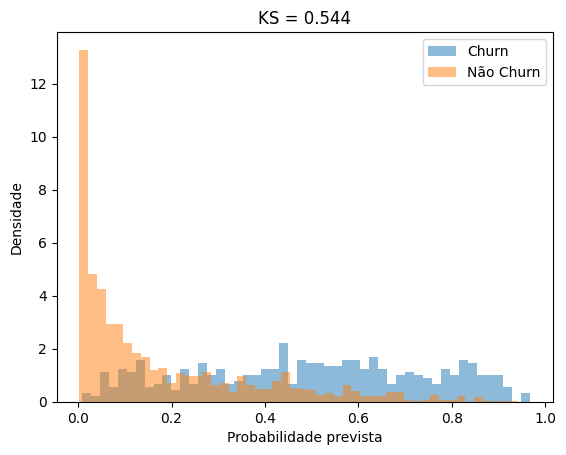

In [ ]:

plt.figure()
plt.hist(proba_churn, bins=50, density=True, alpha=0.5, label="Churn")
plt.hist(proba_no_churn, bins=50, density=True, alpha=0.5, label="Não Churn")
plt.title(f"KS = {ks_stat:.3f}")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Densidade")
plt.legend()
plt.show()


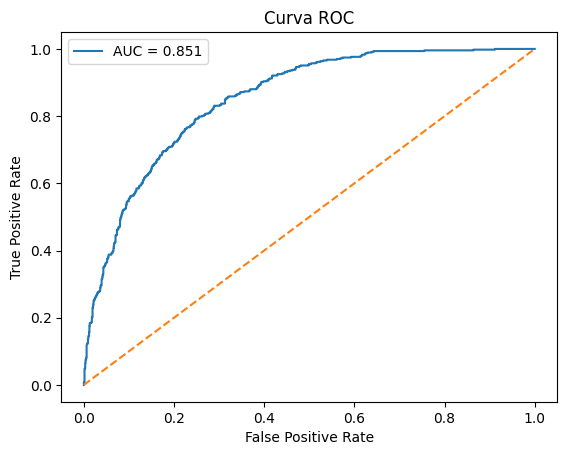

In [ ]:

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

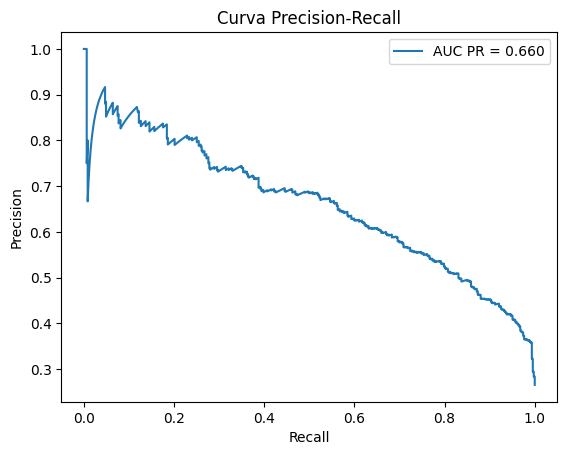

In [ ]:

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"AUC PR = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.show()
